<a href="https://colab.research.google.com/github/Mors666/hopfieldRNN/blob/master/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import numpy as np
from sympy import KroneckerDelta as kron
import matplotlib.pyplot as plt
#import pydot
import time
import random
#from multiprocessing import Process, Queue,set_start_method

In [0]:
n = torch.LongTensor([90]) #общее число работников в организации

C = np.random.randint(0, 11, (n, n)) #затраты ребер графа
C = np.tril(C) + np.tril(C, -1).T #матрица затрат должна быть симметричной
np.fill_diagonal(C, 0, wrap=False)

P = np.random.randint(0, 2, (n, n)) #несуществующие ребра графа
P = np.tril(P) + np.tril(P, -1).T
#P = (P + P.T)/2
np.fill_diagonal(P, 1, wrap=False) 

for i in range(n):
    for j in range(n):
        if P[i][j] == 1:
            C[i][j] = 10

'''print('матрица затрат')
print(C)
print(P)'''

C = torch.from_numpy(C) 
P = torch.from_numpy(P) 

In [0]:
mu1 =torch.FloatTensor([950.]) #3000
mu2 = torch.FloatTensor([475.]) #480
mu3 = torch.FloatTensor([1500.]) #50000
mu4 = torch.FloatTensor([2500.]) #15000
mu5 = torch.FloatTensor([2500.]) #50000

In [601]:
A = torch.FloatTensor([0.0001])  
B = torch.FloatTensor([0.00001]) 
D = torch.FloatTensor([0.00001]) 

ex_number = np.around(n.mul(2/3), decimals=0) # 2/3 - кол-во исполнителей относительно общего числа работников
director = 0 #номер узла, соответствующего топ-менеджеру в иерархии
executors = random.sample(range(1,n), int(ex_number)) #случайно выбранные индексы исполнителей  
print(executors)

[31, 17, 70, 32, 22, 7, 29, 3, 34, 33, 88, 64, 41, 87, 51, 11, 9, 19, 71, 69, 26, 60, 24, 84, 5, 16, 50, 36, 79, 2, 62, 8, 81, 30, 55, 15, 83, 82, 57, 76, 49, 1, 6, 78, 18, 45, 73, 38, 46, 61, 86, 65, 4, 56, 27, 75, 52, 59, 68, 77]


In [0]:
def init_weights():
    start = time.time()
      
    for x in range(n):
        for i in range(n):
            for y in range(n):
                for j in range(n):
                 
                    weights[x*n+i,y*n+j] = mu2*torch.tensor(kron(x, y)*kron(i, j),dtype=torch.float64) - mu4*torch.tensor(kron(x, y),dtype=torch.float64) - mu4*torch.tensor(kron(i, j),dtype=torch.float64) + mu4*torch.tensor(kron(j, x),dtype=torch.float64) + mu4*torch.tensor(kron(i, y),dtype=torch.float64)
    
    finish = time.time()
    result = finish - start
    print("Время на инициализацию матрицы весов: " + str(result) + " секунд")
    return weights
    '''start = time.time()
     
      
    for x in range(n):
        for i in range(n):
            for y in range(n):
                for j in range(n):
                    if x==y==i==j:
                        weights[n*x+i,n*y+j] = mu2
                    elif x==y and i==j and j!=x:
                        weights[n*x+i,n*y+j] = mu2.sub(mu4.sub(mu4))  
                    elif (x==y and i!=j and (j==x or i==y)) or (x!=y!=i!=j) or (x!=y and i==j and (j==x or i==y)):
                        weights[n*x+i,n*y+j] = 0.
                    elif x!=y and i!=j and j==x and i==y:
                        weights[n*x+i,n*y+j] =  mu4.add(mu4)  
                    elif x!=y and i!=j and (j==x or i==y):    
                        weights[n*x+i,n*y+j] = mu4
                    elif (x==y or i==j) and j!=x and i!=y:
                        weights[n*x+i,n*y+j] = -mu4
                     
                    #weights[n*x+i,n*y+j] = mu2.mul(torch.FloatTensor([kron(x, y)*kron(i, j)]).cuda()) - mu4.mul(torch.FloatTensor([kron(x, y)]).cuda()) - mu4.mul(torch.FloatTensor([kron(i, j)]).cuda()) + mu4.mul(torch.FloatTensor([kron(j, x)]).cuda()) + mu4.mul(torch.FloatTensor([kron(i, y)]).cuda())
                    #mu2*kron(x, y)*kron(i, j) - mu4*kron(x, y) - mu4*kron(i, j) + mu4*kron(j, x) + mu4*kron(i, y)
    
    finish = time.time()
    result = finish - start
    print("Время на инициализацию матрицы весов: " + str(result) + " секунд")
    return weights'''

In [0]:
def energy(m,OUT, ftype):
    #OUT = K.reshape(OUT, (n,n))
    #ftype = ftype + OUT
    OUT = OUT.resize_((n,n)) 
    E1 = torch.FloatTensor([0]) 
    E2 = torch.FloatTensor([0]) 
    E3 = torch.FloatTensor([0]) 
    E4 = torch.FloatTensor([0]) 
    E5 = torch.FloatTensor([0]) 
    
    for x in range(n):
        for i in range(n):
            if (i != x) and (x!=m and i!=director):
                E1 = E1.add(torch.mul(C[x][i], torch.mul(torch.div(1,torch.add(1,ftype[x][i])),OUT[x][i]))) 
                #E1 + C[x][i]*(1/(1+ftype[x][i]))*OUT[x][i]  
                E3 = E3.add(torch.mul(P[x][i],OUT[x][i]))
                #E3+P[x][i]*OUT[x][i]
            if i != x:
                E2 =  E2.add(torch.mul(OUT[x][i],torch.sub(1,OUT[x][i])))
                #E2 + OUT[x][i]*(1-OUT[x][i])
                 
                
    out1=torch.FloatTensor([0]) 
    out2=torch.FloatTensor([0]) 
    #square=0
    for x in range(n):
        for i in range(n):
            if i != x:
                out1 = out1.add(OUT[x][i])
                #out1+OUT[x][i]
                out2 = out1.add(OUT[i][x])
                #out2+OUT[i][x]
        #square = (out1-out2)*(out1-out2)
        E4 = E4.add(torch.mul(out1.sub(out2),out1.sub(out2)))
        #E4 + (out1-out2)*(out1-out2)
        
    E5 = torch.sub(1,OUT[m][director])
    #1-OUT[m][director]
    
    E =  torch.add(mu1.mul(E1),mu2.mul(E2))
    E = E.add(mu3.mul(E3))
    E = E.add(mu4.mul(E4))
    E = E.add(mu5.mul(E5))
    #torch.add(mu1.mul(E1),torch.add(mu2.mul(E2),torch.add(mu3.mul(E3),torch.add(mu4.mul(E4),torch.add(mu5.mul(E5)))))) 
    #mu1*E1 + mu2*E2 + mu3*E3 + mu4*E4 + mu5*E5
    
    #OUT = K.reshape(OUT, (n*n,1))
    OUT = OUT.resize_((n*n,1))
    return E

In [0]:
def bias_init(ftype,m): #инициализатор смещения нейронов (bias)
    bias = torch.zeros((n*n,1)) 
    idx = 0 
    for x in range (n):
        for i in range (n):
             
            if (x==m and i==director):
                bias[idx] = mu5/2-mu2/2
            else:
                bias[idx] = -mu1/2*C[x][i]*ftype[x][i]-mu3/2*P[x][i]-mu2/2 
            idx = idx + 1;
        #bias=np.concatenate(bias)
    #bias = torch.stack(bias)
    '''b = torch.zeros((n*n,1)).cuda() #np.zeros((n*n,1))
 
    for x in range (n*n):
        b[x][0]= bias[x]
        #b = b.shape((n*n,1))'''
    #print(bias)
    return bias

In [0]:
def input_tensor():  
        IN = np.full((n,n), 0.5 + np.random.uniform(-0.00001, 0.00001, (n,n)))  # 0.00001 
        IN.shape = (n*n,1)
        #IN= torch.from_numpy(IN) 
        inp = torch.tensor(IN,dtype=torch.float64)
        return inp

In [0]:
#torch.set_printoptions(precision=10)
#print(input_tensor())

In [0]:
class RNN(torch.nn.RNNCell):
    def __init__(self, input_size, IN,weights, bias, nonlinearity):
        super(RNN, self).__init__(input_size, hidden_size=input_size, bias=False)
        self.input_size = self.hidden_size = input_size
        self.bias = True
        self.nonlinearity = nonlinearity
        self.prev_in = [] #входные значения с предыдущих итераций
        self.energies = [] #значения функции энергии
        self.prev_energy = torch.tensor([1e10]).float() #np.Infinity #значение энергии на предыдущей итерации
        self.worker = -1 #номер узла исполнителя, для которого используется сеть
        self.stop = False #для остановки в случае увеличения энергии
        self.result = IN#.share_memory_() #выходной сигнал после определенной итерации
        self.weight_ih = self.weight_hh = weights
        #print(self.weight_ih)
        self.bias_ih = self.bias_hh = bias
        #print(self.bias_ih)
        #self.threshold = torch.nn.Threshold(0.5,0)

    def calc_thresholds(self, out):
        #threshold = torch.nn.Threshold(0.5,0)
        #out = threshold(out).float()
        one = torch.tensor([1.0]).float()
        zero = torch.tensor([0.0]).float()
   
        return torch.where(out>0.5,one,zero)

    def forward(self, input, hx=None):
        activation = torch.nn.Sigmoid()
        '''print(self.weight_ih.shape)
        print(input.shape)
        print(self.bias_ih.shape)'''
        #input = input.resize_((1, n*n))
        hx = torch.add(torch.mm(self.weight_ih.float(),input.float()), self.bias_ih)  #torch.add(, self.bias_ih)
        hx = activation(hx)
        inputs = hx
        if len(self.prev_in) ==1:
            inputs = self.prev_in[0] + D*hx
             
        elif len(self.prev_in) ==2:
            inputs =  self.prev_in[1] - A*self.prev_in[0] + D*hx
            
        elif len(self.prev_in) > 2:
            inputs = self.prev_in[len(self.prev_in)-1] - A*self.prev_in[len(self.prev_in)-2] - B*self.prev_in[len(self.prev_in)-3]+ D*hx
             
        self.prev_in.append(inputs)

        return  inputs

In [608]:
weights = torch.zeros((n*n,n*n))  
W = torch.nn.Parameter(init_weights(), requires_grad=False)
#print(W)

Время на инициализацию матрицы весов: 7515.139999389648 секунд


In [0]:
ftype = torch.zeros((n,n))
#m=0
#print(bias_init(ftype,m))

In [0]:
def create_RNN(m):
    mRNN = RNN(n*n,IN= input_tensor(),
                 weights = W , 
                 bias = torch.nn.Parameter(bias_init(ftype,m), requires_grad=False),
                 nonlinearity = "sigmoid")
    mRNN.worker = m
    return mRNN

In [0]:
def one_iteration(HNN):#i,q):
    #print("in one_iteration")
    #mRNN.bias = bias_init(ftype,mRNN.worker)
    output = HNN.forward(HNN.result)
    curr_energy = energy(HNN.worker,output,ftype)
        #print(curr_energy)
    HNN.prev_in.append(output)
    if torch.lt(torch.sub(HNN.prev_energy,curr_energy),torch.tensor([1e-5])):
        print("previous energy:")
        print(HNN.prev_energy)
        print("current energy:")
        print(curr_energy)
      
        HNN.stop = True
        HNN.result = output#mRNN.prev_in[len(mRNN.prev_in)-2]
        HNN.energies.append(curr_energy)
    else:
        #print("in else")
        HNN.prev_energy = curr_energy
        HNN.energies.append(HNN.prev_energy)
        HNN.result = output
        HNN.bias = bias_init(ftype,HNN.worker)
    #print("before q.put")
    #q.put([all_RNN[i].result,all_RNN[i].prev_energy,all_RNN[i].stop,all_RNN[i].prev_in,all_RNN[i].energies])
    #q.put(all_RNN[i].result)

In [0]:
ftype = torch.zeros((n,n))

In [613]:
torch.set_printoptions(precision=8,profile="full")
'''mRNN = create_RNN(2)
mRNN.result = mRNN.forward(mRNN.result)
print(energy(2,mRNN.result,ftype))'''

'mRNN = create_RNN(2)\nmRNN.result = mRNN.forward(mRNN.result)\nprint(energy(2,mRNN.result,ftype))'

In [614]:
'''mRNN.bias = bias_init(ftype,mRNN.worker)
mRNN.result = mRNN.forward(mRNN.result)
print(energy(2,mRNN.result,ftype))'''

'mRNN.bias = bias_init(ftype,mRNN.worker)\nmRNN.result = mRNN.forward(mRNN.result)\nprint(energy(2,mRNN.result,ftype))'

In [615]:
'''torch.set_printoptions(precision=8,profile="full")
mRNN = create_RNN(1)
#mRNN.result = mRNN.forward(mRNN.result)
output = mRNN.forward(mRNN.result)
print(output)
curr_energy = energy(1,output,ftype)
print(curr_energy)
mRNN.prev_in.append(output)
mRNN.bias = bias_init(ftype,mRNN.worker)'''

'torch.set_printoptions(precision=8,profile="full")\nmRNN = create_RNN(1)\n#mRNN.result = mRNN.forward(mRNN.result)\noutput = mRNN.forward(mRNN.result)\nprint(output)\ncurr_energy = energy(1,output,ftype)\nprint(curr_energy)\nmRNN.prev_in.append(output)\nmRNN.bias = bias_init(ftype,mRNN.worker)'

In [616]:
#print(energy(0,mRNN.result,ftype))
'''mRNN.result = output
output = mRNN.forward(mRNN.result)
print(output)
curr_energy = energy(1,output,ftype)
print(curr_energy)'''

'mRNN.result = output\noutput = mRNN.forward(mRNN.result)\nprint(output)\ncurr_energy = energy(1,output,ftype)\nprint(curr_energy)'

In [0]:
#print(mRNN.calc_thresholds(mRNN.result))

In [618]:
'''mRNN.result = mRNN.forward(mRNN.result)
mRNN.bias = bias_init(ftype,mRNN.worker)'''
#print(mRNN.result)

'mRNN.result = mRNN.forward(mRNN.result)\nmRNN.bias = bias_init(ftype,mRNN.worker)'

In [0]:
#print(energy(0,mRNN.result,ftype))

In [0]:
all_start = time.time()

In [621]:
if __name__ == '__main__':
    all_RNN=[]
    #ftype = torch.zeros((n,n))
    for m in executors:
        '''mRNN = RNN(n*n,IN= input_tensor(),
                  weights = W , 
                  bias = torch.nn.Parameter(bias_init(ftype,m), requires_grad=False),
                  nonlinearity = "sigmoid")
        mRNN.worker = m'''
        #mRNN = create_RNN(m)#.share_memory()
            #mRNN.result.share_memory_()
        all_RNN.append(create_RNN(m))
        #print(all_RNN[0].stop)
    
    #print("initial result")
    #print(all_RNN[0].result)
    iterat = 0
    for mRNN in all_RNN:
        mRNN.forward(mRNN.result) 
    while not all(mRNN.stop == True for mRNN in all_RNN) and iterat<10:
        #print(all_RNN[0].stop)
        print("ITERATION " + str(iterat))
        #if iterat>0:
            #for i in range(len(executors)):
             #   ftype = ftype + all_RNN[i].result.resize_((n,n))
              #  all_RNN[i].result = all_RNN[i].result.resize_((n*n,1))
        iterat = iterat + 1

        #for i in range(len(executors)):
        for mRNN in all_RNN:
            if mRNN.stop == False:
                one_iteration(mRNN)

        #print(all_RNN[0].result)
        ftype = torch.zeros((n,n))

    for mRNN in all_RNN:
        OUT = mRNN.calc_thresholds(mRNN.result)#all_RNN[i].calc_thresholds(all_RNN[i].result)
        OUT.resize_((n,n))
        print("Результаты для исполнителя "+str(mRNN.worker)+":") 
        print(OUT)
     

Streaming output truncated to the last 5000 lines.
         0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,

energy values
9436924.0
9436116.0
9435384.0
9434896.0
9434198.0
9433627.0
9432822.0
9432080.0
9431621.0
9430883.0


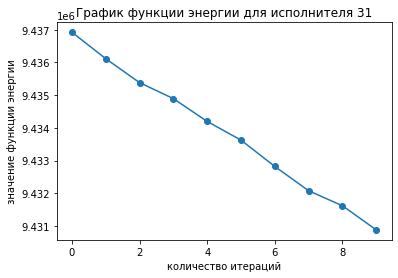

energy values
9462127.0
9461316.0
9460589.0
9460145.0
9459446.0
9458861.0
9458027.0
9457290.0
9456881.0
9456150.0


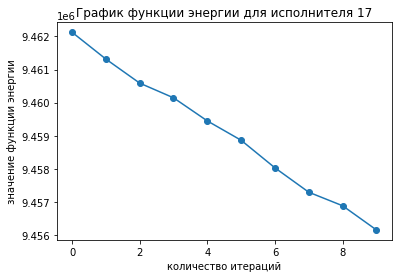

energy values
9462574.0
9461756.0
9461021.0
9460564.0
9459843.0
9459298.0
9458511.0
9457739.0
9457318.0
9456559.0


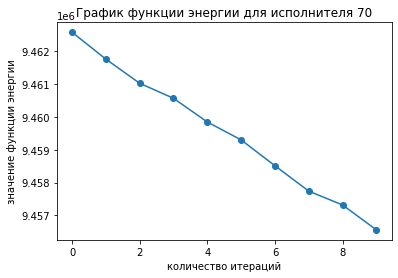

energy values
9433145.0
9432337.0
9431623.0
9431131.0
9430458.0
9429867.0
9429029.0
9428327.0
9427846.0
9427136.0


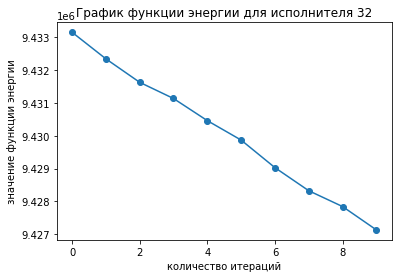

energy values
9474078.0
9473248.0
9472498.0
9472042.0
9471325.0
9470765.0
9469928.0
9469179.0
9468754.0
9467984.0


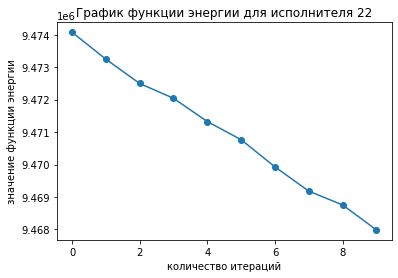

energy values
9475181.0
9474358.0
9473621.0
9473160.0
9472446.0
9471844.0
9471006.0
9470296.0
9469850.0
9469112.0


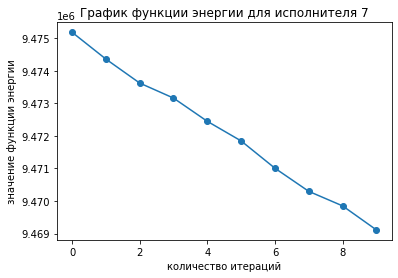

energy values
9466779.0
9465993.0
9465265.0
9464780.0
9464071.0
9463469.0
9462661.0
9461945.0
9461474.0
9460736.0


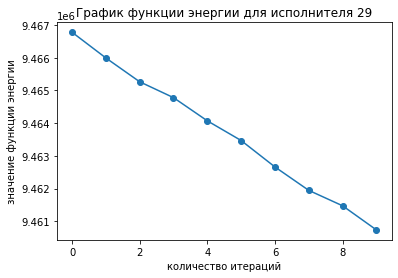

energy values
9476679.0
9475862.0
9475127.0
9474651.0
9473958.0
9473370.0
9472538.0
9471797.0
9471350.0
9470620.0


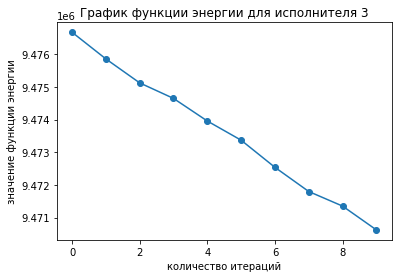

energy values
9456500.0
9455673.0
9454961.0
9454486.0
9453767.0
9453191.0
9452365.0
9451628.0
9451188.0
9450455.0


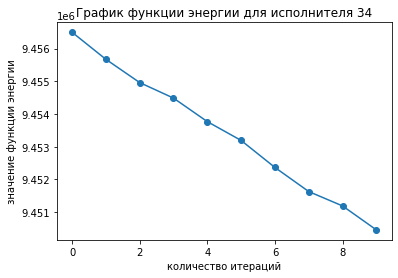

energy values
9479058.0
9478230.0
9477493.0
9477019.0
9476311.0
9475719.0
9474875.0
9474152.0
9473696.0
9472968.0


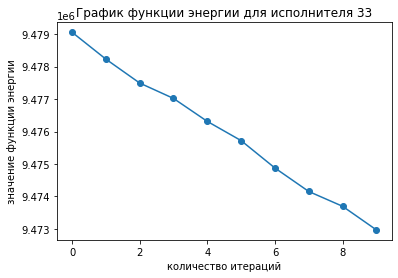

energy values
9444278.0
9443455.0
9442695.0
9442349.0
9441602.0
9441001.0
9440155.0
9439393.0
9439059.0
9438275.0


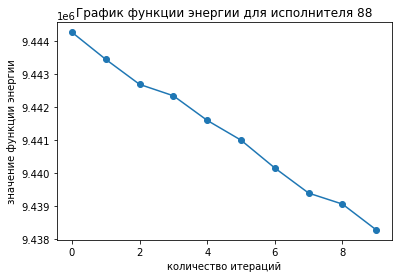

energy values
9488673.0
9487844.0
9487109.0
9486671.0
9485948.0
9485365.0
9484537.0
9483785.0
9483375.0
9482625.0


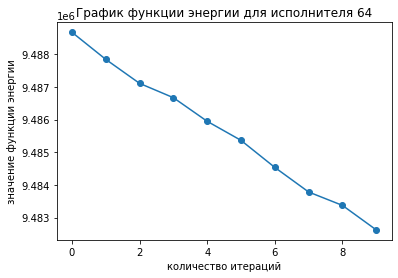

energy values
9467590.0
9466760.0
9466049.0
9465578.0
9464865.0
9464224.0
9463391.0
9462662.0
9462232.0
9461480.0


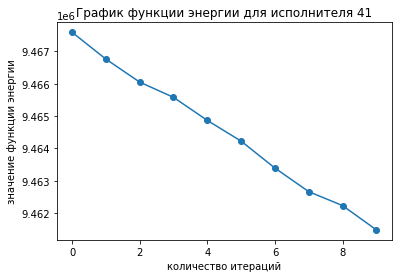

energy values
9483640.0
9482805.0
9482068.0
9481603.0
9480871.0
9480250.0
9479429.0
9478672.0
9478227.0
9477472.0


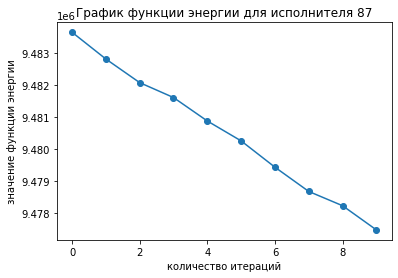

energy values
9451418.0
9450627.0
9449877.0
9449410.0
9448710.0
9448200.0
9447358.0
9446615.0
9446198.0
9445435.0


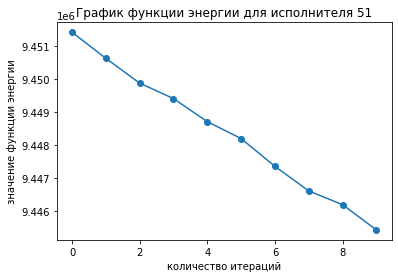

energy values
9428228.0
9427397.0
9426667.0
9426200.0
9425517.0
9424963.0
9424138.0
9423411.0
9422971.0
9422245.0


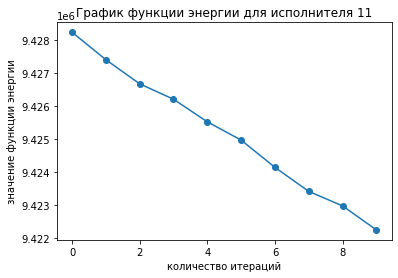

energy values
9437204.0
9436398.0
9435694.0
9435172.0
9434485.0
9433935.0
9433102.0
9432393.0
9431913.0
9431175.0


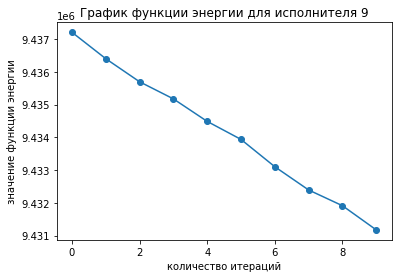

energy values
9468613.0
9467815.0
9467074.0
9466616.0
9465911.0
9465242.0
9464432.0
9463703.0
9463246.0
9462510.0


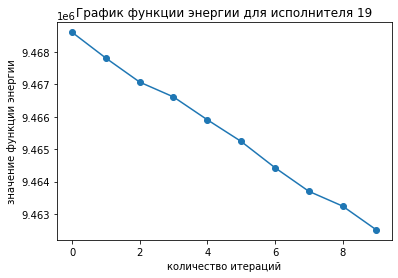

energy values
9463530.0
9462703.0
9461972.0
9461519.0
9460826.0
9460200.0
9459381.0
9458671.0
9458215.0
9457498.0


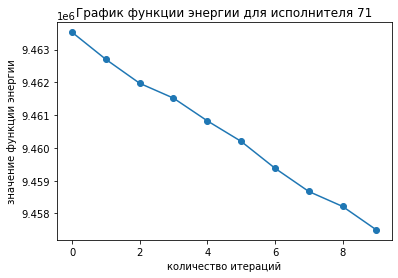

energy values
9432321.0
9431529.0
9430802.0
9430396.0
9429678.0
9429019.0
9428201.0
9427449.0
9427083.0
9426347.0


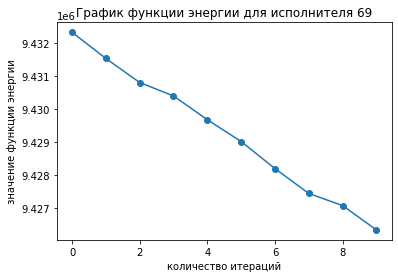

energy values
9407278.0
9406482.0
9405797.0
9405310.0
9404640.0
9404026.0
9403208.0
9402519.0
9402080.0
9401358.0


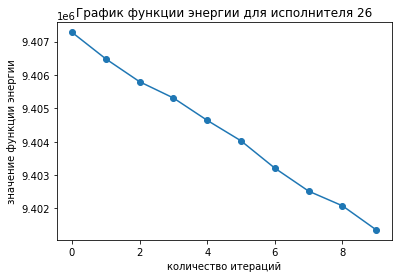

energy values
9444545.0
9443711.0
9442990.0
9442545.0
9441847.0
9441296.0
9440471.0
9439721.0
9439314.0
9438573.0


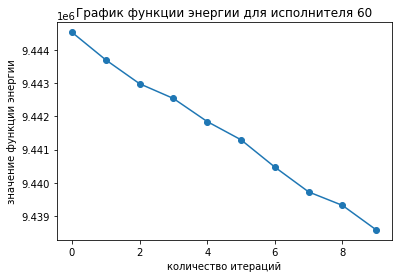

energy values
9465213.0
9464416.0
9463688.0
9463202.0
9462524.0
9461897.0
9461080.0
9460366.0
9459908.0
9459181.0


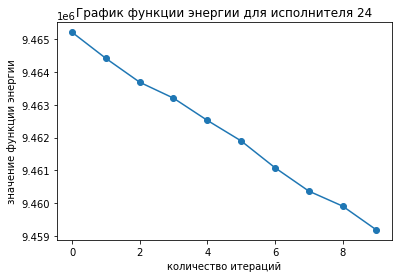

energy values
9466985.0
9466169.0
9465448.0
9465024.0
9464321.0
9463650.0
9462818.0
9462099.0
9461717.0
9460970.0


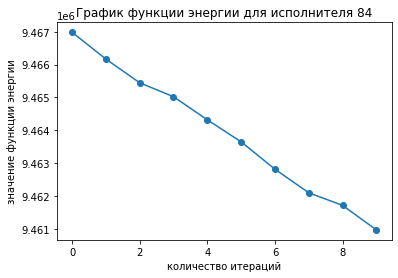

energy values
9459134.0
9458319.0
9457567.0
9457107.0
9456406.0
9455867.0
9455030.0
9454283.0
9453864.0
9453115.0


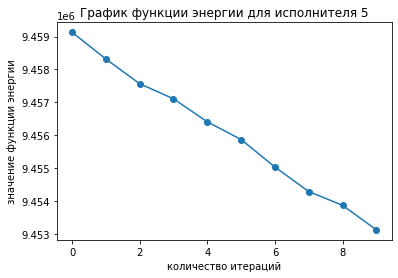

energy values
9427114.0
9426301.0
9425567.0
9425122.0
9424410.0
9423894.0
9423074.0
9422316.0
9421901.0
9421144.0


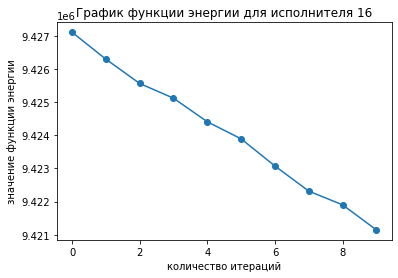

energy values
9460054.0
9459248.0
9458508.0
9458070.0
9457353.0
9456761.0
9455935.0
9455174.0
9454776.0
9454040.0


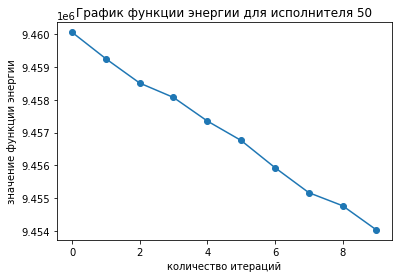

energy values
9437796.0
9436978.0
9436247.0
9435884.0
9435154.0
9434493.0
9433626.0
9432912.0
9432561.0
9431827.0


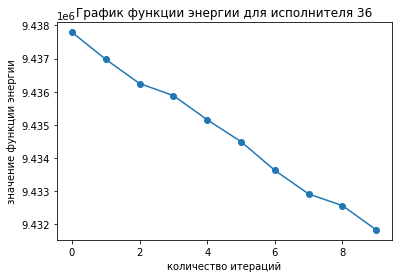

energy values
9450638.0
9449817.0
9449097.0
9448666.0
9447968.0
9447293.0
9446484.0
9445725.0
9445330.0
9444602.0


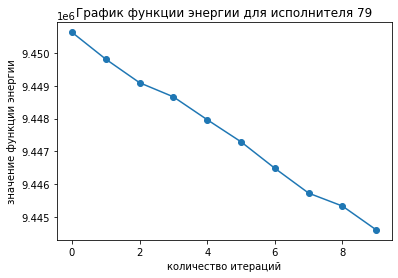

energy values
9476448.0
9475627.0
9474873.0
9474406.0
9473688.0
9473138.0
9472306.0
9471538.0
9471126.0
9470366.0


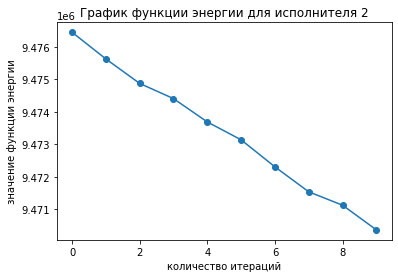

energy values
9459568.0
9458742.0
9458031.0
9457551.0
9456861.0
9456245.0
9455408.0
9454708.0
9454263.0
9453531.0


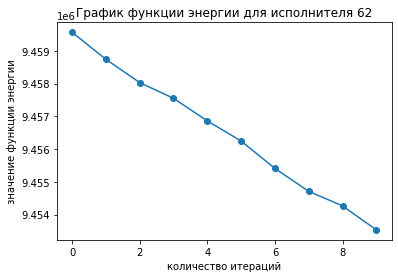

energy values
9447396.0
9446586.0
9445882.0
9445363.0
9444707.0
9444128.0
9443284.0
9442595.0
9442120.0
9441387.0


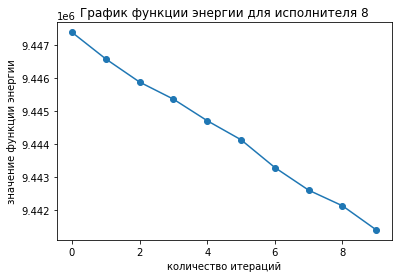

energy values
9464170.0
9463354.0
9462597.0
9462185.0
9461479.0
9460842.0
9459999.0
9459261.0
9458851.0
9458112.0


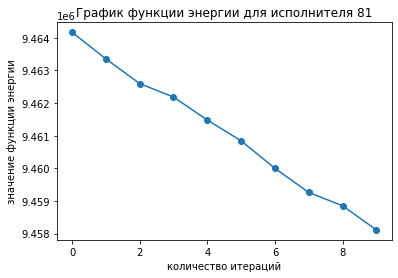

energy values
9498489.0
9497636.0
9496898.0
9496446.0
9495734.0
9495157.0
9494331.0
9493558.0
9493138.0
9492383.0


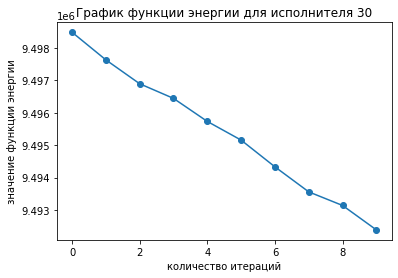

energy values
9510927.0
9510111.0
9509363.0
9508926.0
9508220.0
9507538.0
9506693.0
9505969.0
9505563.0
9504800.0


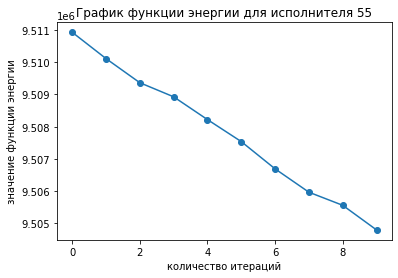

energy values
9448398.0
9447591.0
9446852.0
9446415.0
9445722.0
9445072.0
9444251.0
9443522.0
9443099.0
9442366.0


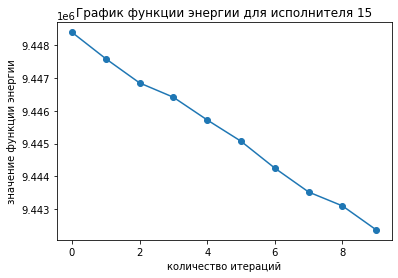

energy values
9476450.0
9475634.0
9474886.0
9474419.0
9473726.0
9473104.0
9472278.0
9471540.0
9471131.0
9470364.0


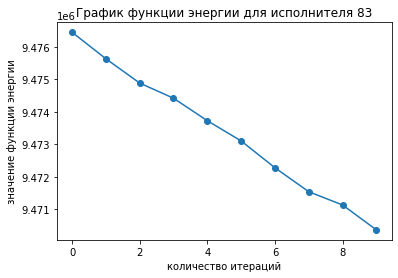

energy values
9473258.0
9472442.0
9471689.0
9471314.0
9470574.0
9469933.0
9469098.0
9468331.0
9467958.0
9467181.0


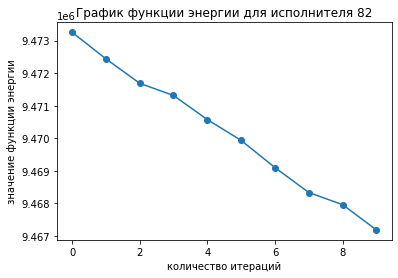

energy values
9461648.0
9460804.0
9460085.0
9459614.0
9458931.0
9458328.0
9457495.0
9456778.0
9456346.0
9455595.0


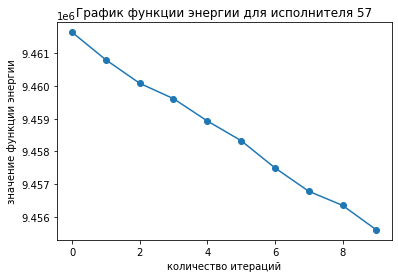

energy values
9424620.0
9423796.0
9423056.0
9422642.0
9421918.0
9421406.0
9420582.0
9419822.0
9419448.0
9418707.0


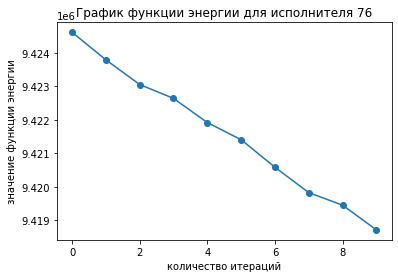

energy values
9496679.0
9495878.0
9495111.0
9494664.0
9493947.0
9493313.0
9492452.0
9491731.0
9491302.0
9490525.0


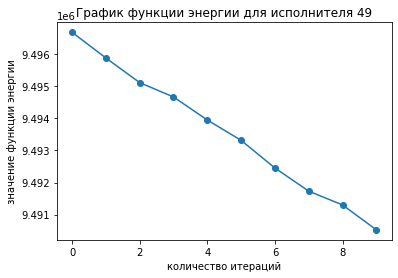

energy values
9473207.0
9472397.0
9471683.0
9471170.0
9470461.0
9469902.0
9469080.0
9468369.0
9467837.0
9467150.0


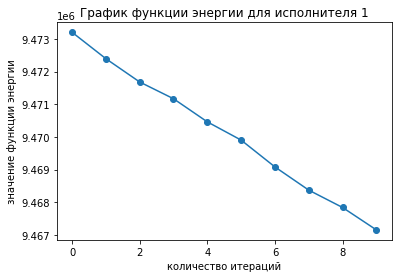

energy values
9498084.0
9497246.0
9496511.0
9496069.0
9495359.0
9494734.0
9493863.0
9493160.0
9492703.0
9491977.0


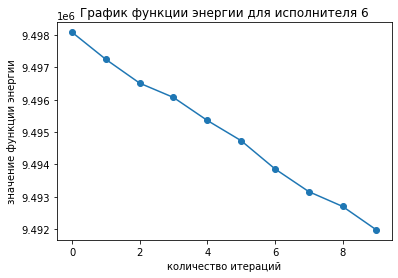

energy values
9455702.0
9454886.0
9454167.0
9453723.0
9453052.0
9452402.0
9451568.0
9450853.0
9450430.0
9449702.0


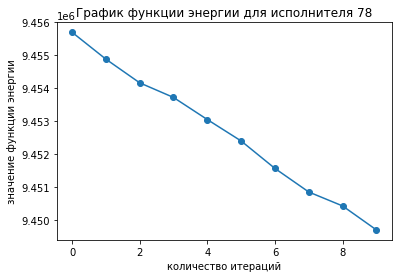

energy values
9450289.0
9449501.0
9448764.0
9448323.0
9447628.0
9446991.0
9446181.0
9445472.0
9445024.0
9444309.0


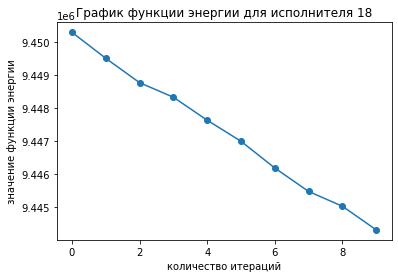

energy values
9481030.0
9480205.0
9479450.0
9478984.0
9478285.0
9477698.0
9476858.0
9476106.0
9475699.0
9474921.0


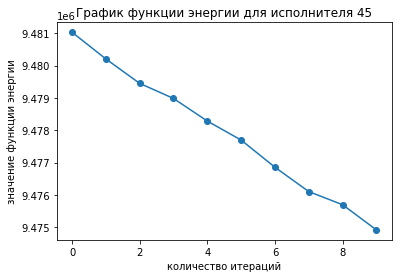

energy values
9434995.0
9434175.0
9433434.0
9433029.0
9432304.0
9431686.0
9430858.0
9430115.0
9429705.0
9428992.0


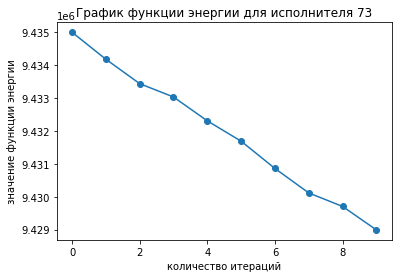

energy values
9482353.0
9481508.0
9480783.0
9480300.0
9479616.0
9479007.0
9478191.0
9477449.0
9477008.0
9476236.0


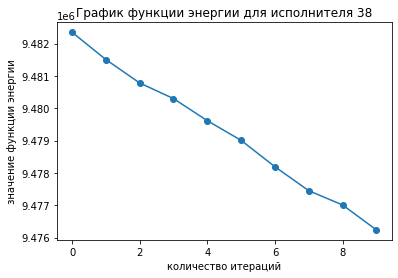

energy values
9438294.0
9437478.0
9436717.0
9436298.0
9435572.0
9435042.0
9434212.0
9433462.0
9433071.0
9432297.0


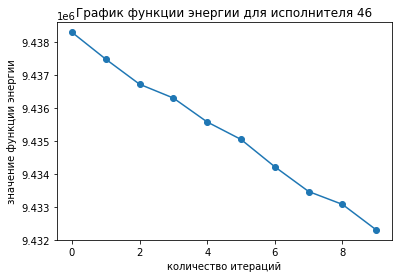

energy values
9440733.0
9439936.0
9439217.0
9438739.0
9438066.0
9437467.0
9436633.0
9435933.0
9435473.0
9434762.0


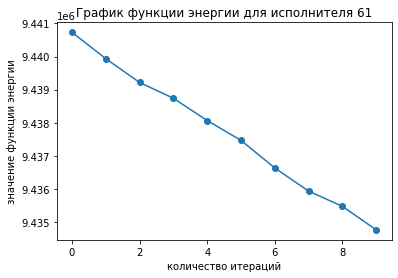

energy values
9495818.0
9494991.0
9494249.0
9493789.0
9493067.0
9492458.0
9491622.0
9490891.0
9490441.0
9489694.0


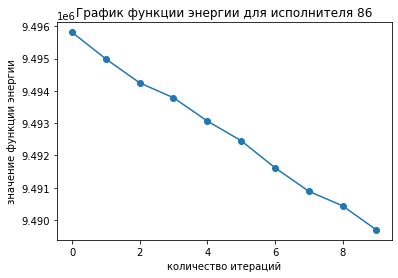

energy values
9420427.0
9419626.0
9418897.0
9418455.0
9417773.0
9417171.0
9416353.0
9415626.0
9415212.0
9414485.0


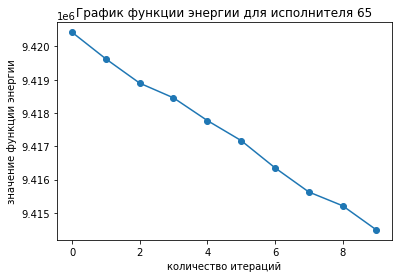

energy values
9461450.0
9460615.0
9459862.0
9459447.0
9458722.0
9458145.0
9457325.0
9456576.0
9456186.0
9455418.0


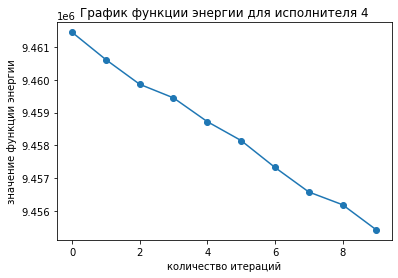

energy values
9460030.0
9459206.0
9458456.0
9458000.0
9457284.0
9456739.0
9455921.0
9455175.0
9454749.0
9454008.0


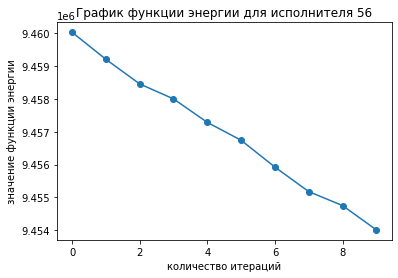

energy values
9482068.0
9481263.0
9480519.0
9480074.0
9479346.0
9478769.0
9477939.0
9477186.0
9476789.0
9476008.0


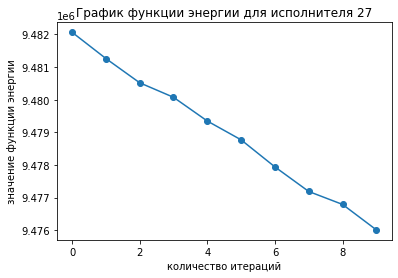

energy values
9472291.0
9471457.0
9470763.0
9470238.0
9469540.0
9468991.0
9468184.0
9467459.0
9466969.0
9466234.0


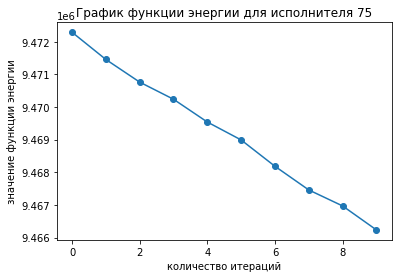

energy values
9424704.0
9423903.0
9423184.0
9422772.0
9422086.0
9421444.0
9420614.0
9419878.0
9419496.0
9418753.0


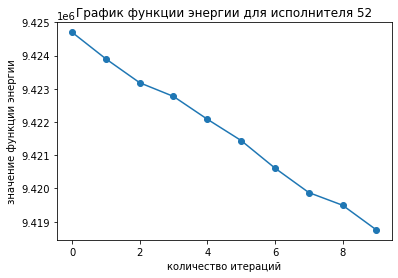

energy values
9413114.0
9412302.0
9411601.0
9411137.0
9410439.0
9409840.0
9409004.0
9408307.0
9407871.0
9407147.0


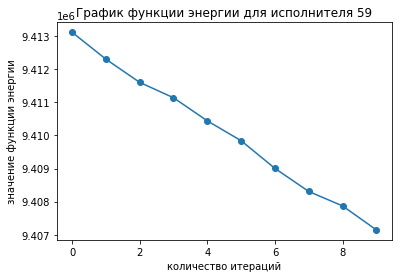

energy values
9481845.0
9481022.0
9480272.0
9479821.0
9479092.0
9478526.0
9477697.0
9476968.0
9476525.0
9475763.0


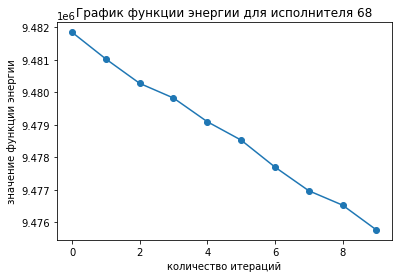

energy values
9455508.0
9454674.0
9453939.0
9453473.0
9452769.0
9452202.0
9451356.0
9450623.0
9450178.0
9449431.0


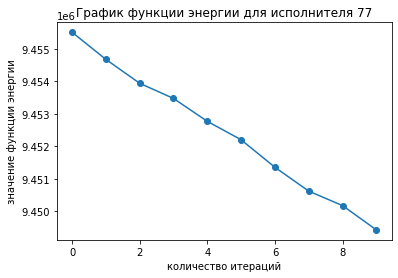

In [622]:
for mRNN in  all_RNN:
    iterations = np.arange(0,len(mRNN.energies))
#print(iterations)
#print(len(energies))
    e =  np.zeros((len(mRNN.energies),))
#print(e)
    print("energy values")
    for i in range(len(mRNN.energies)):
        e[i] = mRNN.energies[i]
         
        print(e[i])
    #print(K.eval(energies[i]))
#j=0
#for i in range(0,len(mRNN.energies),10):
    #energy[j] = K.eval(mRNN.energies[i])
    #j=j+1
        
    plt.plot(iterations,e, marker='o')
    plt.title("График функции энергии для исполнителя "+str(mRNN.worker))
    plt.xlabel("количество итераций")
    plt.ylabel("значение функции энергии")
    plt.show()

In [0]:
#for i in range(len(executors)):
        #for mRNN in all_RNN:
    #print(all_RNN[i].stop)

In [624]:
all_finish = time.time()
all_result = all_finish - all_start
print("Общее время: " + str(all_result) + " секунд")

Общее время: 793.3240492343903 секунд


In [625]:
'''if __name__ == '__main__':
    #set_start_method('spawn')
    all_RNN=[]
    for m in executors:
        mRNN = create_RNN(m)#.share_memory()
        #mRNN.result.share_memory_()
        all_RNN.append(mRNN)
    print(all_RNN[0].result)
    iterat = 0
    while not all(mRNN.stop == True for mRNN in all_RNN) and iterat<10:
        #mRNN.share_memory()
        print(iterat)
        #print(iterat)
        if iterat>0:
            for i in range(len(executors)):
                ftype = ftype + all_RNN[i].result.resize_((n,n))
        iterat = iterat + 1
        #param = np.Infinity
        queues = []
        #queue = Queue()
        procs = []

        for i in range(len(executors)):
            if (all_RNN[i].stop == False):
                queue = Queue()
                queues.append(queue)
                p = Process(target=one_iteration, args=(i,queue,))
                procs.append(p)
                print("process"+str(len(procs)))     
                p.start()
             
        j=0
         
        for i in range(len(executors)):
             
            if (all_RNN[i].stop == False) :
                 
                #print(queues[j].get())
                #[all_RNN[i].result,all_RNN[i].prev_energy,all_RNN[i].stop,all_RNN[i].prev_in,all_RNN[i].energies] = queues[j].get()
                #all_RNN[i].result = queues[j].get()
                j = j+1
                    
                #[all_RNN[i].result,all_RNN[i].prev_energy,all_RNN[i].stop] = queue.get()
                #all_RNN[i].energies.append(all_RNN[i].prev_energy)
            
        for proc in procs:
            proc.join()
            #print("process joined") 
        j=0
        for i in range(len(executors)):
             
            if (all_RNN[i].stop == False) :
                 
                print(queues[j].get())
                j = j+1 
            #ftype = ftype + K.eval(all_RNN[i].result).reshape(n,n)
            #print(ftype)
            
        ftype = torch.zeros((n,n)) 
    print(all_RNN[0].result)'''

'if __name__ == \'__main__\':\n    #set_start_method(\'spawn\')\n    all_RNN=[]\n    for m in executors:\n        mRNN = create_RNN(m)#.share_memory()\n        #mRNN.result.share_memory_()\n        all_RNN.append(mRNN)\n    print(all_RNN[0].result)\n    iterat = 0\n    while not all(mRNN.stop == True for mRNN in all_RNN) and iterat<10:\n        #mRNN.share_memory()\n        print(iterat)\n        #print(iterat)\n        if iterat>0:\n            for i in range(len(executors)):\n                ftype = ftype + all_RNN[i].result.resize_((n,n))\n        iterat = iterat + 1\n        #param = np.Infinity\n        queues = []\n        #queue = Queue()\n        procs = []\n\n        for i in range(len(executors)):\n            if (all_RNN[i].stop == False):\n                queue = Queue()\n                queues.append(queue)\n                p = Process(target=one_iteration, args=(i,queue,))\n                procs.append(p)\n                print("process"+str(len(procs)))     \n           